# Big G Express Model Data Prep: Target & Stratifier

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Read in

In [2]:
faults = pd.read_pickle('../data/faults_df.pickle')
diag = pd.read_pickle('../data/diag_df.pickle')
fdwide = pd.read_pickle('../data/fdwide_df.pickle')

## Add grouping column to fdwide: eventGroup

Note that this event grouper includes 75% derate events. If we choose not to include those events, that part of the logic can easily be removed.

In [3]:
fdwide = fdwide.sort_values(['EquipmentID', 'EventTimeStamp']).reset_index(drop = True)

## Create target column within target_hours_window number of hours, both derate types or just full derate types

### Functionalize Target Creation

In [4]:
def create_target_window(df, both_derate_types = False, target_window_hours = 48):

    df2 = df.copy()
    df2 = df2.sort_values(['EquipmentID', 'EventTimeStamp']).reset_index(drop = True)

    if both_derate_types:

        increment_check_either = (
    
                (df2['spn'].shift() == 5246)  # full derate in above row
                | 
                ((df2['spn'].shift() == 1569) & (df2['fmi'].shift() == 31))   # partial derate in above row
                | 
                (df2['EquipmentID'] != df2['EquipmentID'].shift())    # current row is different truck from previous row

            )

        df2['eventGroup'] = increment_check_either.cumsum()
        eventGroupMaxIndexTransform = df2.groupby('eventGroup')['EventTimeStamp'].transform('idxmax') # get the max index of each event group
        eventGroupEndDerate = (     
                (
                    (df2.loc[eventGroupMaxIndexTransform, 'spn'] == 5246) # full derate
                    |
                    ((df2.loc[eventGroupMaxIndexTransform, 'spn'] == 1569) & (df2.loc[eventGroupMaxIndexTransform, 'fmi'] == 31)) # partial derate
                )
                .reset_index(drop = True)
            )       # check whether or not each event group ends with a derate

    else:    

        increment_check_full_only = (

                (df2['spn'].shift() == 5246)  # full derate in above row
                | 
                (df2['EquipmentID'] != df2['EquipmentID'].shift())    # current row is different truck from previous row

            )

        df2['eventGroup'] = increment_check_full_only.cumsum()
        eventGroupMaxIndexTransform = df2.groupby('eventGroup')['EventTimeStamp'].transform('idxmax')   # get the max index of each event group
        eventGroupEndDerate = (df2.loc[eventGroupMaxIndexTransform, 'spn'] == 5246).reset_index(drop = True) # check whether or not each event group ends with a derate

    df2['timeTillLast'] = df2.groupby('eventGroup')['EventTimeStamp'].transform(max) - df2['EventTimeStamp']
    df2['target'] = (df2['timeTillLast'] < dt.timedelta(hours = target_window_hours)) & eventGroupEndDerate
    
    return df2

In [5]:
both48 = create_target_window(fdwide, both_derate_types= True)
both48['target'].mean()

0.03004291122555976

In [6]:
both48['target'].sum()

35671

In [7]:
full48 = create_target_window(fdwide, both_derate_types=False)
full48['target'].mean()


0.0059275604610324805

In [8]:
full48['target'].sum()

7038

In [9]:
# For exploration of how event groups conclude
eG = 9
(full48.loc[full48['eventGroup'] == eG, 
          ['EventTimeStamp','EquipmentID','eventGroup', 'spn', 'fmi', 'timeTillLast', 'target']]
          .tail(15)
)

,EventTimeStamp,EquipmentID,eventGroup,spn,fmi,timeTillLast,target
5137,2020-01-07 03:08:33,302,9,1213,5,6 days 09:06:31,False
5138,2020-01-07 12:02:12,302,9,1213,5,6 days 00:12:52,False
5139,2020-01-13 02:38:29,302,9,609,12,0 days 09:36:35,True
5140,2020-01-13 07:06:03,302,9,609,12,0 days 05:09:01,True
5141,2020-01-13 12:15:04,302,9,5246,19,0 days 00:00:00,True


## Thinking about Train-Test-Split Stratification Strategies

1. Cut the data into train, test, validate by giving the first 60% of events (in chronological order) to training, the next 20% to testing, and the final 20% to validation.
2. As a refinement of above, do the same 60-20-20 division by truck, taking each truck's first 60% of events (in chronological order) and combining those all together to make the training data, then likewise with the test data, and finally likewise with the validation data.

### 1. Train-Test-Validate by Time Alone

We have some impossible data (2026?!) that we should throw out.

In [10]:
fdwide['EventTimeStamp'].sort_values().tail(5)

1119954   2020-03-06 14:14:13
1119955   2020-03-06 14:15:34
759852    2026-05-16 14:44:11
759853    2026-05-16 14:44:11
759854    2026-05-16 14:44:11
Name: EventTimeStamp, dtype: datetime64[ns]

Here's the distribution of events by year. Looks like almost all events are between 2015 and 2019.

In [11]:
fdwide['EventTimeStamp'].dt.year.value_counts().sort_index()

2000       219
2002         1
2009        24
2010        58
2011       244
2015    325779
2016    332383
2017    254851
2018    144510
2019    112075
2020     17188
2026         3
Name: EventTimeStamp, dtype: int64

<AxesSubplot:>

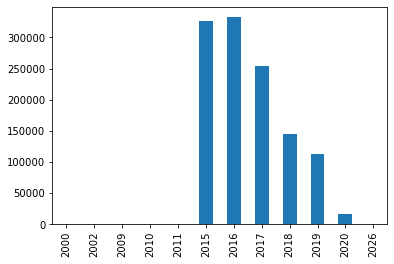

In [12]:
_.plot(kind='bar')

Based on the quantiles below, our 
- training data will run from 2000 till 2017-03-05 09:59:10
- testing data will run from 2017-03-05 09:59:10 till 2018-03-07 06:48:45
- validation data will run from 2018-03-07 06:48:45 till 2020-03-06 14:15:34

In [13]:
fdwide['EventTimeStamp'].quantile(0.6)

Timestamp('2017-03-05 09:59:10')

In [14]:
fdwide['EventTimeStamp'].quantile(0.8)

Timestamp('2018-03-07 06:48:45.400000')

The primary concern with a custom cut like this is that our labels might not be adequately stratified. Based on the check below, this stratification at least looks usable. There are more positive cases in the validation set, but not by any orders of magnitude.

In [15]:
(full48.assign(train_test_val = pd.qcut(full48['EventTimeStamp'], 
                                          q = [0, 0.6, 0.8, 1], 
                                          labels = ['train', 'test', 'validation']))
       .groupby('train_test_val')
       ['target']
       .agg(['mean', 'sum'])
)

,mean,sum
train_test_val,,
train,0.005743,4091
test,0.003984,946
validation,0.008426,2001


### 2. Train-Test-Validate by Truck and Time

In [16]:
breaks = [0.6, 0.8, 1.0]
conditions_list = [full48['EventTimeStamp'].le(full48.groupby('EquipmentID')['EventTimeStamp'].transform(lambda x: x.quantile(val))) for val in breaks]
choice_list = ['train', 'test', 'validate']

(full48.assign(train_test_val = np.select(conditions_list, choice_list))
       .groupby('train_test_val')
       ['target']
       .agg(['mean', 'sum'])
)

,mean,sum
train_test_val,,
test,0.005564,1319
train,0.004614,3289
validate,0.010233,2430


### Functionaliize Stratification Labels

In [17]:
def stratifier(df, trucks = False, breaks = [0.6, 0.8, 1.0]):
    df2 = df.copy()
    if trucks:
        conditions_list = [df2['EventTimeStamp'].le(df.groupby('EquipmentID')['EventTimeStamp'].transform(lambda x: x.quantile(val))) for val in breaks]
        choice_list = ['train', 'test', 'validate']

        df2['train_test_val'] = np.select(conditions_list, choice_list)
    else:
        df2['train_test_val'] = pd.qcut(df2['EventTimeStamp'], 
                                          q = [0] + breaks, 
                                          labels = ['train', 'test', 'validation']).astype(str)
    return df2

In [18]:
stratifier(full48, trucks = False).groupby('train_test_val')['target'].agg(['mean','sum'])

,mean,sum
train_test_val,,
test,0.003984,946
train,0.005743,4091
validation,0.008426,2001


In [20]:
stratifier(full48, trucks = True).groupby('train_test_val')['target'].agg(['mean','sum'])

,mean,sum
train_test_val,,
test,0.005564,1319
train,0.004614,3289
validate,0.010233,2430
